# Homework 2

In [1]:
import pandas as pd

import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize # сегментация русскоязычного текста на токены и предложения
import pymorphy2

In [2]:
news = pd.read_csv('articles.csv')
print(news.shape)
news.head(2)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...


In [3]:
news.iloc[2]['title']

'Форвард «Авангарда» Томаш Заборский прокомментировал игру своей команды в матче чемпионата КХЛ против «Атланта»n(4:3)n.nn«Мы провели плохой матч в Нижнем Новгороде против «Торпедо» и настраивались, что с первых же минут включимся в работу, — сказал Заборский. — У нас получилось забросить быстрый гол и задать хороший темп поединку. Мы можем играть еще лучше, но, с другой стороны, пять очков на выезде из девяти — это лучше, чем ничего».'

In [4]:
users = pd.read_csv('users_articles.csv')
users.sample(3)

,uid,articles
4712,u102960,"[6964, 7715, 7811, 7049, 5000, 513170]"
6475,u101610,"[7534, 7083, 5640, 7510, 6037, 488013]"
1590,u107990,"[322363, 322859, 322753, 323591, 323431, 470763]"


In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adurz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [7]:
with open('stopwords.txt', encoding='utf-8') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]

In [8]:
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
# очистка текста

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
        
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub('-\s\r\n\|-\s\r\n|\r\n', '', str(text))
    
    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

In [10]:
cache = {}
morph = pymorphy2.MorphAnalyzer()

In [11]:
# Лемматизация

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''
    
    # [0]
    if not isinstance(text, str):
        text = str(text)
        
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]
    
    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru]
    
    return words_lem_without_stopwords

In [12]:
news['title'].iloc[:2].apply(lambda x: clean_text(x))

C:\Users\adurz\AppData\Local\Temp/ipykernel_4624/415316496.py:11: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [13]:
%%time

from tqdm import tqdm
tqdm.pandas()

news['title'] = news['title'].progress_apply(clean_text)

100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [00:27<00:00, 990.11it/s]

Wall time: 27.4 s


In [14]:
news['title'].iloc[:2]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [15]:
news['title'].iloc[:2].apply(lambda x: lemmatization(x))

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
Name: title, dtype: object

In [16]:
%%time

news['title'] = news['title'].progress_apply(lemmatization)

100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [03:13<00:00, 139.85it/s]

Wall time: 3min 13s


In [17]:
# формируем список наших текстов
texts = list(news['title'].values)

In [18]:
# Создаем корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [19]:
len(common_dictionary)

135645

In [56]:
# Количество тем

N_topic = 30

In [57]:
# %%time
# from gensim.models import LdaModel

# # Обучаем модель на корпусе
# lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary
#                , passes=15
#               )

Wall time: 14min 4s


In [138]:
# from gensim.test.utils import datapath

# # Сохраняем модель на диск
# temp_file = datapath('D:\GB\ML-business\model.lda')
# lda.save(temp_file)

In [191]:
# загружаем обученную модель с диска
lda = LdaModel.load('.\model.lda')

In [192]:
# Создаем новый корпус документов, которые раньше не видели

other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[1]
print(other_texts[1])
pfs = lda[unseen_doc]

['матч', 'финал', 'кубок', 'россия', 'футбол', 'приостановить', 'судья', 'изз', 'взрыв', 'пиротехнический', 'снаряд', 'передавать', 'корреспондент', 'газета', 'ru', 'болельщик', 'выбросить', 'поле', 'петарда', 'судья', 'увести', 'команда', 'поле', 'подтрибунный', 'помещение', 'динамовец', 'уйти', 'торпедовец', 'остаться', 'кромка', 'поле', 'матч', 'остановить', 'пять', 'минута', 'газета', 'ru', 'вести', 'онлайнтрансляция', 'матч']


In [193]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

In [194]:
# Печатаем только слова
for topic, words in topics_words:
    print(f'topic_{topic}: ' + ' '.join(words))

topic_0: ребёнок мозг школа семья родитель памятник помещение
topic_1: агентство станция центр объект москва дом житель
topic_2: проект мероприятие сайт фестиваль участник участие праздник
topic_3: иск фотография умереть жена юрист польский автобус
topic_4: млн тыс продажа составить место около вырасти
topic_5: земля миссия кризис небо знаменитый изучение треть
topic_6: медведев золото награда балл золотой россия лесной
topic_7: законодательство мальчик девочка годовой су дворец вход
topic_8: военный сила российский наука россия оборона часть
topic_9: сша американский ракета новый система китай российский
topic_10: газ погибнуть турция европа турецкий франция польша
topic_11: сотрудник управление поток задержать эксперимент китайский строительство
topic_12: гражданин население россиянин доллар доля расти актив
topic_13: северный запуск южный корея ким дания la
topic_14: статья писать изз час британский день газета
topic_15: всё очень большой новый первый научный ru
topic_16: россия рос

In [195]:
# векторное представление новости

def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))
    
    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [196]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06194016, 0.14583793, 0.        , 0.04091108, 0.        ,
       0.05789844, 0.21056148, 0.        , 0.        , 0.        ,
       0.11397315, 0.        , 0.        , 0.        , 0.36146417])

In [197]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])

Wall time: 1min 7s


In [198]:
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]

In [199]:
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id'] + [f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,6,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.057879,0.210620,0.0,0.0,0.000000,0.113974,0.000000,0.0,0.0,0.361533
1,4896,0.02797,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.454149,...,0.000000,0.000000,0.0,0.0,0.000000,0.442866,0.000000,0.0,0.0,0.000000
2,4897,0.00000,0.0,0.00000,0.000000,0.0,0.052786,0.0,0.0,0.000000,...,0.041178,0.000000,0.0,0.0,0.060951,0.651175,0.052331,0.0,0.0,0.000000
3,4898,0.00000,0.0,0.02343,0.012221,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.349820,0.000000,0.0,0.0,0.000000
4,4899,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.183478,0.0,0.0,0.000000,0.175192,0.000000,0.0,0.0,0.361601


## Векторное представление пользователей

In [68]:
users.shape

(8000, 2)

In [69]:
users.sample(3)

,uid,articles
2858,u106929,"[324112, 323731, 324157, 323829, 322732, 1065]"
3109,u102127,"[6827, 7053, 6970, 5051, 6694, 486952]"
7471,u103195,"[324322, 324361, 323301, 324290, 322518, 532628]"


In [70]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [71]:
doc_dict[47]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01189702, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.13191241, 0.49928585, 0.01244019, 0.        , 0.        ,
       0.        , 0.02290852, 0.        , 0.        , 0.31245282])

In [72]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = np.mean(user_vector, axis=0)
    return user_vector

In [73]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

array([0.01368267, 0.0420059 , 0.00292164, 0.        , 0.01294848,
       0.00207841, 0.        , 0.00419895, 0.0750339 , 0.06617599,
       0.        , 0.02477282, 0.03320883, 0.        , 0.02366039,
       0.10889946, 0.14983191, 0.        , 0.00192743, 0.03666404,
       0.03580128, 0.20148891, 0.01524172, 0.        , 0.0676374 ,
       0.        , 0.00179751, 0.00213397, 0.00237755, 0.06016655])

In [74]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid'] + [f'topic_{i}' for i in range(N_topic)]]

Wall time: 318 ms


In [75]:
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,u105138,0.043193,0.055397,0.084175,0.007529,0.006536,0.005892,0.000000,0.001815,0.030715,...,0.037632,0.156350,0.000000,0.000000,0.033757,0.037136,0.0,0.0,0.010118,0.101990
1,u108690,0.017036,0.019337,0.010996,0.000000,0.014791,0.000000,0.002726,0.002535,0.058456,...,0.055123,0.110994,0.003811,0.004853,0.054013,0.011311,0.0,0.0,0.020973,0.069272
2,u108339,0.015560,0.110288,0.018051,0.001811,0.019119,0.001766,0.000000,0.002970,0.064320,...,0.048358,0.181333,0.020230,0.002685,0.031545,0.008613,0.0,0.0,0.041237,0.081707


In [76]:
target = pd.read_csv('users_churn.csv')
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [77]:
X = pd.merge(user_embeddings, target, 'left')

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                     X['churn'], random_state=2)

In [80]:
logreg = LogisticRegression()
# Обучение
logreg.fit(X_train, y_train)

LogisticRegression()

In [81]:
# Прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.23076076, 0.1601464 , 0.0173193 , 0.11052273, 0.08975951,
       0.0019217 , 0.14370686, 0.08955514, 0.10400558, 0.00405794])

Рассчитаем Precision, Recall, F-score

In [82]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve,
                            confusion_matrix)

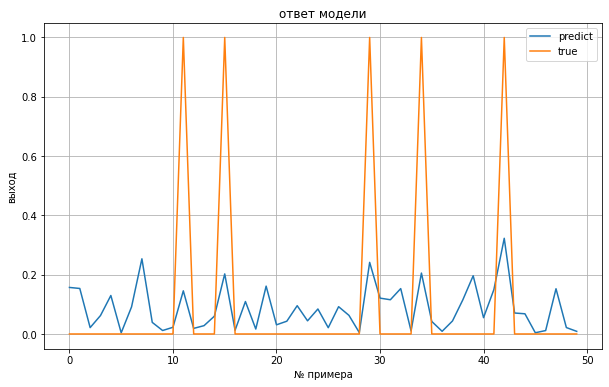

In [50]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [83]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# находим индекс наилучшего f-score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.27369284462329685, F-Score=0.749, Precision=0.794, Recall=0.709


In [84]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1711   45]
 [  72  172]]


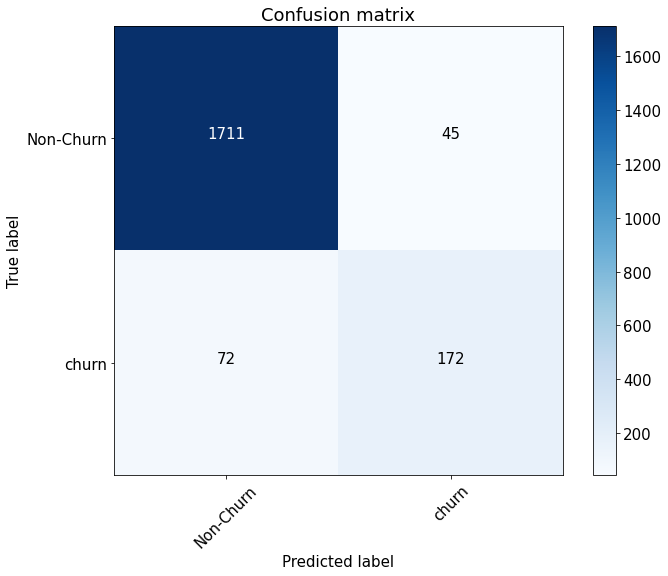

In [85]:
import itertools
font = {'size': 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                     title='Confusion matrix')

# plt.savefig('conf_matrix.png')
plt.show()

In [86]:
roc_auc_score(y_test, preds)

0.9634204974046828

In [87]:
mean_precision = precision[ix]
mean_recall = recall[ix]
mean_fscore = fscore[ix]
mean_roc_auc = roc_auc_score(y_test, preds)

# Домашнее задание

### 1. *Самостоятельно повторить tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [89]:
docs = pd.read_csv('articles.csv')

In [90]:
docs = docs['title'].progress_apply(clean_text)

100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [00:27<00:00, 999.07it/s]


In [91]:
tf = TfidfVectorizer(stop_words=stopword_ru, max_features=100)

In [92]:
tf.fit(docs)

C:\Users\adurz\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['_ссылка', 'всё', 'интерфакс', 'как_сообщили_риа_', 'новости', 'передает_риа_', 'сообщает_', 'сообщает_риа_'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=100,
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

In [93]:
tf_docs = pd.DataFrame.sparse.from_spmatrix(tf.transform(docs), columns=tf.get_feature_names_out())

In [94]:
tf_docs.insert(0, 'doc_id', news['doc_id'].values)

C:\Users\adurz\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


In [95]:
tf_docs.head(3)

,doc_id,безопасности,будут,владимир,власти,вопрос,газетеru,глава,говорит,говорится,...,сша,территории,тыс,украины,ходе,частности,часть,числе,является,января
0,6,0.0,0.0,0.0,0.287383,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4896,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4897,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)

In [96]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = np.median(user_vector, axis=0)
    return user_vector

In [97]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid'] + [f'topic_{i}' for i in range(N_topic)]]

Wall time: 910 ms


In [98]:
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,u105138,0.034551,0.019027,0.107272,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.128452,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.056376
1,u108690,0.000000,0.008695,0.000000,0.0,0.000000,0.0,0.0,0.0,0.062784,...,0.017392,0.089187,0.0000,0.0,0.038711,0.000000,0.0,0.0,0.000000,0.044822
2,u108339,0.011829,0.107985,0.000000,0.0,0.008958,0.0,0.0,0.0,0.063250,...,0.037851,0.213482,0.0051,0.0,0.041432,0.007986,0.0,0.0,0.034399,0.067344


In [99]:
X = pd.merge(user_embeddings, target, 'left')

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                     X['churn'], random_state=2)

In [101]:
logreg = LogisticRegression()
# Обучение
logreg.fit(X_train, y_train)

LogisticRegression()

In [102]:
# Прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

Рассчитаем Precision, Recall, F-score

In [103]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# находим индекс наилучшего f-score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.24454727646924118, F-Score=0.788, Precision=0.732, Recall=0.852


In [104]:
median_precision = precision[ix]
median_recall = recall[ix]
median_fscore = fscore[ix]
median_roc_auc = roc_auc_score(y_test, preds)

### 3. Повторить п.2, но используя уже не медиану, а max

In [416]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = np.max(user_vector, axis=0)
    return user_vector

In [417]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid'] + [f'topic_{i}' for i in range(N_topic)]]

Wall time: 465 ms


In [418]:
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,u105138,0.121629,0.149492,0.153344,0.045175,0.039215,0.035352,0.000000,0.010888,0.124485,...,0.113378,0.348942,0.000000,0.000000,0.111858,0.123533,0.0,0.0,0.060705,0.294358
1,u108690,0.072568,0.074451,0.065974,0.000000,0.064825,0.000000,0.016357,0.015210,0.079887,...,0.159778,0.234606,0.022863,0.017688,0.123317,0.048558,0.0,0.0,0.099364,0.162357
2,u108339,0.043532,0.240098,0.108307,0.010864,0.053018,0.010593,0.000000,0.017821,0.113294,...,0.155107,0.286597,0.096785,0.016107,0.056472,0.018620,0.0,0.0,0.107992,0.197617


In [419]:
X = pd.merge(user_embeddings, target, 'left')

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                     X['churn'], random_state=2)

In [421]:
logreg = LogisticRegression()
# Обучение
logreg.fit(X_train, y_train)

LogisticRegression()

In [422]:
# Прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

Рассчитаем Precision, Recall, F-score

In [424]:
X_train.sum(axis=1)

5853    2.635926
148     2.576874
6394    2.866343
423     2.767675
5214    2.478003
          ...   
3606    3.487737
5704    2.469412
6637    3.029377
2575    2.802136
7336    3.022828
Length: 6000, dtype: float64

In [112]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# находим индекс наилучшего f-score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.35336013077654765, F-Score=0.839, Precision=0.846, Recall=0.832


In [113]:
max_precision = precision[ix]
max_recall = recall[ix]
max_fscore = fscore[ix]
max_roc_auc = roc_auc_score(y_test, preds)

### 4. *Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)
 - подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал
 - подсказка 2: нужен именно idf, как вес.

In [293]:
doc_idf = tf_docs.drop(columns=['doc_id']).sum(axis=1)

In [294]:
doc_idf = pd.concat([tf_docs['doc_id'], doc_idf], axis=1)
doc_idf.rename(columns={0: 'idf'}, inplace=True)
doc_idf.head(3)

,doc_id,idf
0,6,1.906151
1,4896,1.394919
2,4897,1.881910


In [372]:
tf_dict = dict(zip(doc_idf['doc_id'].values, doc_idf['idf'].values))
tf_dict[6]

1.9061513639930987

In [373]:
def get_user_embedding(user_articles_list, doc_idf):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_idf[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = np.sum(user_vector, axis=0)
    return user_vector

In [374]:
user_articles_list = users['articles'].iloc[35]

In [375]:
user_articles_list

'[294035, 293677, 294069, 294632, 294579, 3217]'

In [376]:
user_articles_list = eval(user_articles_list)
np.array([tf_dict[doc_id] for doc_id in user_articles_list])

array([1.79038914, 1.38639231, 1.69762336, 2.89539367, 2.041155  ,
       3.71605778])

In [377]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, tf_dict))])

Wall time: 275 ms


In [378]:
user_embeddings.rename(columns={0: 'user_idf'}, inplace=True)
user_embeddings.head(3)

,user_idf
0,14.919805
1,23.587216
2,23.237851


In [379]:
user_embeddings.insert(0, 'uid', users['uid'].values)

In [380]:
user_embeddings.head(3)

,uid,user_idf
0,u105138,14.919805
1,u108690,23.587216
2,u108339,23.237851


In [381]:
X = pd.merge(user_embeddings, target, 'left')

In [382]:
X.head(3)

,uid,user_idf,churn
0,u105138,14.919805,0
1,u108690,23.587216,1
2,u108339,23.237851,1


In [383]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['uid', 'churn']),
                                                     X['churn'], random_state=2)

In [384]:
logreg = LogisticRegression()
# Обучение
logreg.fit(X_train, y_train)

LogisticRegression()

In [385]:
# Прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([1.83553084e-05, 1.91743204e-04, 2.48400101e-11, 5.05839732e-04,
       5.54130368e-06, 3.13931616e-11, 1.46739849e-04, 1.84396351e-03,
       9.62938433e-14, 1.26670621e-12])

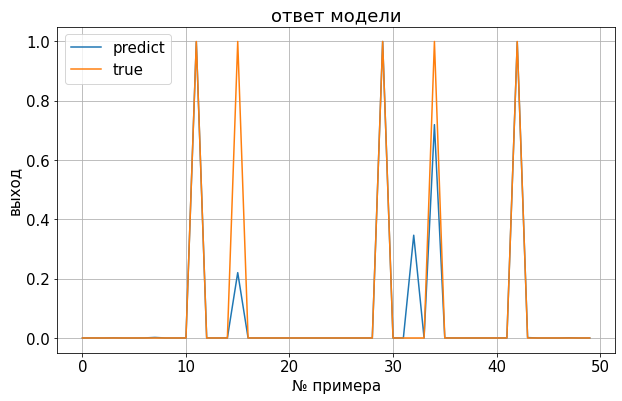

In [386]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

Рассчитаем Precision, Recall, F-score

In [387]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# находим индекс наилучшего f-score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.5444664965300398, F-Score=0.961, Precision=0.967, Recall=0.955


In [407]:
y_train

5853    0
148     1
6394    0
423     1
5214    0
       ..
3606    0
5704    0
6637    0
2575    0
7336    0
Name: churn, Length: 6000, dtype: int64

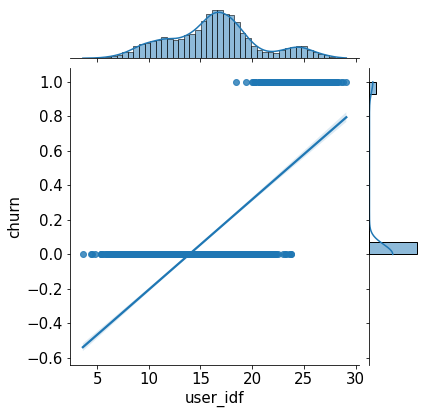

In [413]:
import seaborn as sns

sns.jointplot(x=X_train['user_idf'], y=y_train, kind='reg')
plt.xlabel('Суммарный вес просмотренных новостей')
plt.ylabel('Вероятность оттока клиента')
plt.show()

Наблюдается прямая связь между суммой весов документов и вероятностью ухода клиента

In [391]:
idf_precision = precision[ix]
idf_recall = recall[ix]
idf_fscore = fscore[ix]
idf_roc_auc = roc_auc_score(y_test, preds)

### 5. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [392]:
pd.DataFrame({'fscore': [mean_fscore, median_fscore, max_fscore, idf_fscore],
             'precision': [mean_precision, median_precision, max_precision, idf_precision],
             'recall': [mean_recall, median_recall, max_recall, idf_recall],
             'roc_auc_score': [mean_roc_auc, median_roc_auc, max_roc_auc, idf_roc_auc]},
             index=['mean', 'median', 'max', 'idf'])

,fscore,precision,recall,roc_auc_score
mean,0.748918,0.793578,0.709016,0.963420
median,0.787879,0.732394,0.852459,0.972023
max,0.838843,0.845833,0.831967,0.977867
idf,0.960825,0.966805,0.954918,0.998289


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

- Самым эффективным получился способ оценки оттока клиентов по весу документов, просматриваемых пользователем.
- При рассмотрении применения объединения документов в группы получается самый высокий результат при взятии максимального коэффициента тематик документов из всех доступных документов, прочитанных пользователем. Это может получится из-за слишком маленького количества данных о просмотре документов каждым пользователем (всего 6 документов), так как нельзя понять средний интерес пользователя исходя всего из 6 документов, поэтому лучшим выходом становится взять в общем количестве максимальные значения коэффициентов содержания тем из документов.
- показатели эффективности модели при прогнозировании на медиане лучше прогнозирования на средних коэффициентов может быть потому, что некоторые новости могут быть выбросные (случайно зашел пользователь). Например: человек увлекается спортом и посмотрел пять документов о спорте с коэф. 0.9, а один документ зашел случайно с коэффициентом темы спорт 0.01, из этого следует, median = 0.9, mean = 0.75. (получается есть вероятности выбросов, т.е. случайных документов) 